In [27]:
import numpy as np
import matplotlib.pyplot as plt

from tda.common.measurement import Measurement
from tda.sim.ground_truth import GroundTruth

from tda.sim.sim_engine import Simulation
from tda.sim.sim_objects.lti_object import LTIObject
from tda.sim.sensors.oracle import Oracle

from tda.tracker.filters.linear_kalman import LinearKalman
from tda.tracker.track import Track
from tda.tracker.tracker import Tracker
from tda.tracker.tracker_param import TrackerParam

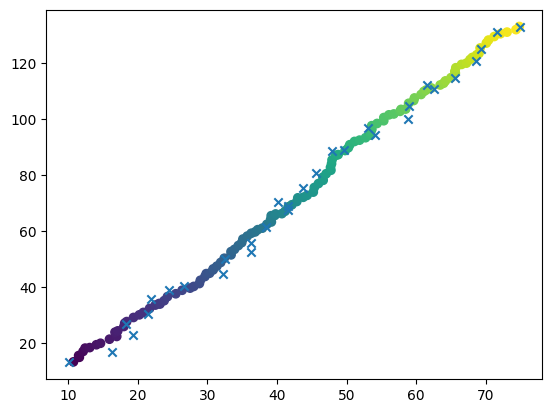

In [48]:
sim = Simulation()

platform = LTIObject(1, np.array([0, 0, 0]), sim, np.zeros((3, 3)))
oracle = Oracle(1, platform, 2.0, np.eye(3) * 2.25)
platform.add_payload(oracle)

target_Q = np.zeros((6, 6))
target_Q[0, 0] = 0.25
target_Q[1, 1] = 0.33

target = LTIObject(2, np.array([10, 12, 0, 1, 2, 0]), sim, target_Q)

sim._sim_objects.extend([platform, target])

sim_records = sim.run()

gt = sim._sim_objects[-1].ground_truth


plt.scatter([x[0] for (t, x) in gt.history], [x[1] for (t, x) in gt.history], c=sim_records["lti_object2"]["t"])
plt.scatter(sim_records["oracle1"]["target_x"], sim_records["oracle1"]["target_y"], marker="x")
#plt.scatter(sim_records["oracle1"]["target_x"] + sim_records["oracle1"]["sensor_x"], sim_records["oracle1"]["target_y"] + sim_records["oracle1"]["sensor_y"], marker="x")

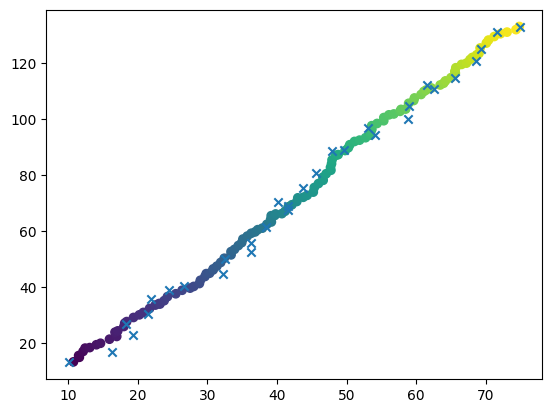

In [49]:
meas_x = list()
meas_y = list()

for f in sim.meas_queue:
    for m in f:
        meas_x.append(m.y[0])
        meas_y.append(m.y[1])


plt.scatter([x[0] for (t, x) in gt.history], [x[1] for (t, x) in gt.history], c=sim_records["lti_object2"]["t"])
plt.scatter(meas_x, meas_y, marker="x")

In [50]:
def F(dt: float):
    F = np.eye(6, dtype=np.float64)
    F[0, 3] = F[1, 4] = F[2, 5] = dt

    return F

def Q(dt: float):
    Q = np.zeros((6, 6))
    Q[0, 0] = 0.35
    Q[1, 1] = 0.35

    return dt * Q

H = np.array([[1, 0, 0, 1, 0, 0],
              [0, 1, 0, 0, 1, 0],
              [0, 0, 1, 0, 0, 1]])

def hinv(y):
    return np.array([y[0], y[1], y[2], 0, 0, 0])

R = 3 * np.eye(3)


In [51]:
def lkf_factory(meas: Measurement) -> Track:
    x0_hat = hinv(meas.y) # + np.concatenate((meas.sensor_pos, [0, 0, 0]))
    P0_hat = np.eye(6) * 1e9

    return LinearKalman(x0_hat, P0_hat, F, H, Q, R)
    

tracker_params = TrackerParam(associator_type="truth",
                              initeator_type="truth",
                              deletor_type="miss_based",
                              filter_factory=lkf_factory)

tracker = Tracker(tracker_params)

In [52]:
for frame in sim.meas_queue:
    tracker.process_frame(frame)

kf_record = tracker.tracks[0].filter.record()

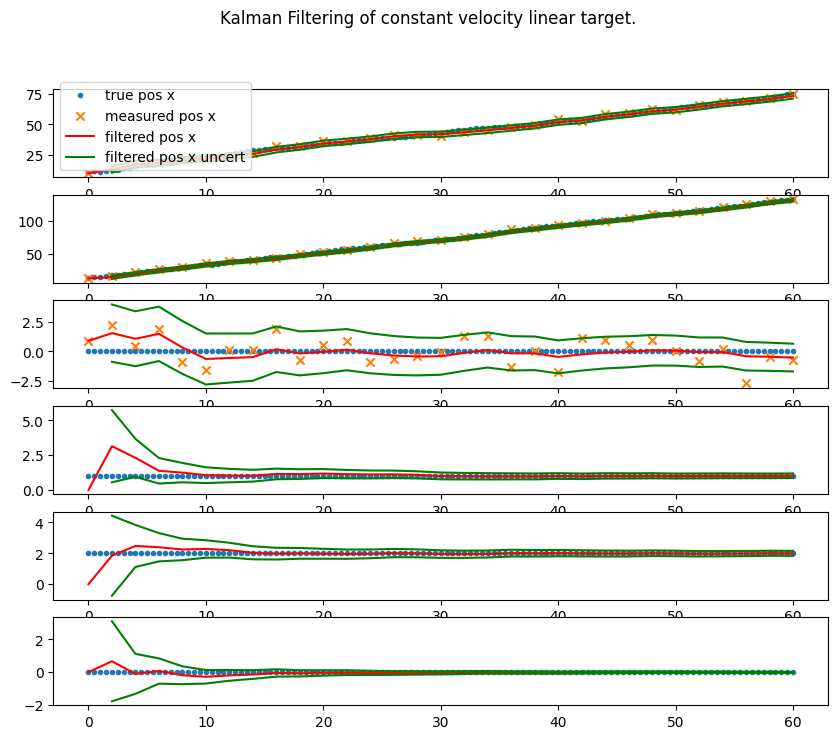

In [53]:
track = tracker.tracks[0]

fig, axs = plt.subplots(6)
fig.suptitle("Kalman Filtering of constant velocity linear target.")
fig.set_size_inches((10, 8))
axs[0].scatter([t for (t, x) in gt.history], [x[0] for (t, x) in gt.history], marker=".", label="true pos x")
axs[0].scatter(sim_records["oracle1"]["t"], sim_records["lti_object1"]["x"][0] \
               + sim_records["oracle1"]["target_x"], marker="x", label="measured pos x")

filtered_x, uncert_x, time_x = track.get_state_hist(0)

axs[0].plot(time_x, sim_records["lti_object1"]["x"][0] +filtered_x, color="red", label="filtered pos x")
axs[0].plot(time_x[1:], sim_records["lti_object1"]["x"][0] + uncert_x[1:, 0], color="green", label="filtered pos x uncert")
axs[0].plot(time_x[1:], sim_records["lti_object1"]["x"][0] + uncert_x[1:, 1], color="green")
axs[0].legend()

axs[1].scatter([t for (t, x) in gt.history], [x[1] for (t, x) in gt.history], marker=".", label="true pos x")
axs[1].scatter(sim_records["oracle1"]["t"], sim_records["lti_object1"]["y"][0] \
               + sim_records["oracle1"]["target_y"], marker="x", label="measured pos x")

filtered_y, uncert_y, time_y = track.get_state_hist(1)

axs[1].plot(time_y, sim_records["lti_object1"]["y"][0] +filtered_y, color="red", label="filtered pos y")
axs[1].plot(time_y[1:], sim_records["lti_object1"]["y"][0] + uncert_y[1:, 0], color="green", label="filtered pos y uncert")
axs[1].plot(time_y[1:], sim_records["lti_object1"]["y"][0] + uncert_y[1:, 1], color="green")

axs[2].scatter([t for (t, x) in gt.history], [x[2] for (t, x) in gt.history], marker=".", label="true pos z")
axs[2].scatter(sim_records["oracle1"]["t"], sim_records["lti_object1"]["z"][0] \
               + sim_records["oracle1"]["target_z"], marker="x", label="measured pos z")

filtered_z, uncert_z, time_z = track.get_state_hist(2)

axs[2].plot(time_z, sim_records["lti_object1"]["z"][0] +filtered_z, color="red", label="filtered pos z")
axs[2].plot(time_z[1:], sim_records["lti_object1"]["z"][0] + uncert_z[1:, 0], color="green", label="filtered pos z uncert")
axs[2].plot(time_z[1:], sim_records["lti_object1"]["z"][0] + uncert_z[1:, 1], color="green")

axs[3].scatter([t for (t, x) in gt.history], [x[3] for (t, x) in gt.history], marker=".", label="true xdot")

filtered_xdot, uncert_xdot, time_xdot = track.get_state_hist(3)

axs[3].plot(time_xdot, filtered_xdot, color="red", label="filtered xdot")
axs[3].plot(time_xdot[1:], uncert_xdot[1:, 0], color="green", label="filtered xdot uncert")
axs[3].plot(time_xdot[1:], uncert_xdot[1:, 1], color="green")

axs[4].scatter([t for (t, x) in gt.history], [x[4] for (t, x) in gt.history], marker=".", label="true ydot")

filtered_ydot, uncert_ydot, time_ydot = track.get_state_hist(4)

axs[4].plot(time_ydot, filtered_ydot, color="red", label="filtered ydot")
axs[4].plot(time_ydot[1:], uncert_ydot[1:, 0], color="green", label="filtered ydot uncert")
axs[4].plot(time_ydot[1:], uncert_ydot[1:, 1], color="green")

axs[5].scatter([t for (t, x) in gt.history], [x[5] for (t, x) in gt.history], marker=".", label="true zdot")

filtered_zdot, uncert_zdot, time_zdot = track.get_state_hist(5)

axs[5].plot(time_zdot, filtered_zdot, color="red", label="filtered zdot")
axs[5].plot(time_zdot[1:], uncert_zdot[1:, 0], color="green", label="filtered zdot uncert")
axs[5].plot(time_zdot[1:], uncert_zdot[1:, 1], color="green")

In [59]:
def compute_error(gt: GroundTruth, tr: Track):
    err = np.zeros((len(tr.state_hist), 6))
    uncert = np.zeros_like(err)
    ts = np.zeros(len(tr.state_hist))
    for i, (x_hat, P, t) in enumerate(tr.state_hist):
        found = False
        for h in gt.history:
            if np.isclose(h[0], t):
                err[i] = h[1] - x_hat
                found = True
                break

        if not found:
            print(f"did not find ground truth from time {t}")

        for j in range(6):
            uncert[i, j] = 2 * np.sqrt(P[j, j])

        ts[i] = t

    return err, uncert, ts


def plot_errors(err, uncert, ts, title=""):
    fig, axs = plt.subplots(6, sharex=True)
    fig.set_size_inches((8, 10))
    fig.suptitle(title)

    states = ["x", "y", "z", "xdot", "ydot", "zdot"]
    units = ["m", "m", "m", "m^2", "m^2", "m^2"]

    for i in range(6):
        axs[i].set_title(states[i])
        axs[i].set_ylabel(units[i])
        axs[i].plot(ts, err[:, i], label="x_hat err")
        axs[i].plot(ts[1:], -uncert[1:, i], color="green", linestyle="dashed", label="2 sigma uncert")
        axs[i].plot(ts[1:], uncert[1:, i], color="green", linestyle="dashed")

    axs[0].legend()
    axs[5].set_xlabel("time")

    fig.tight_layout()

    return fig

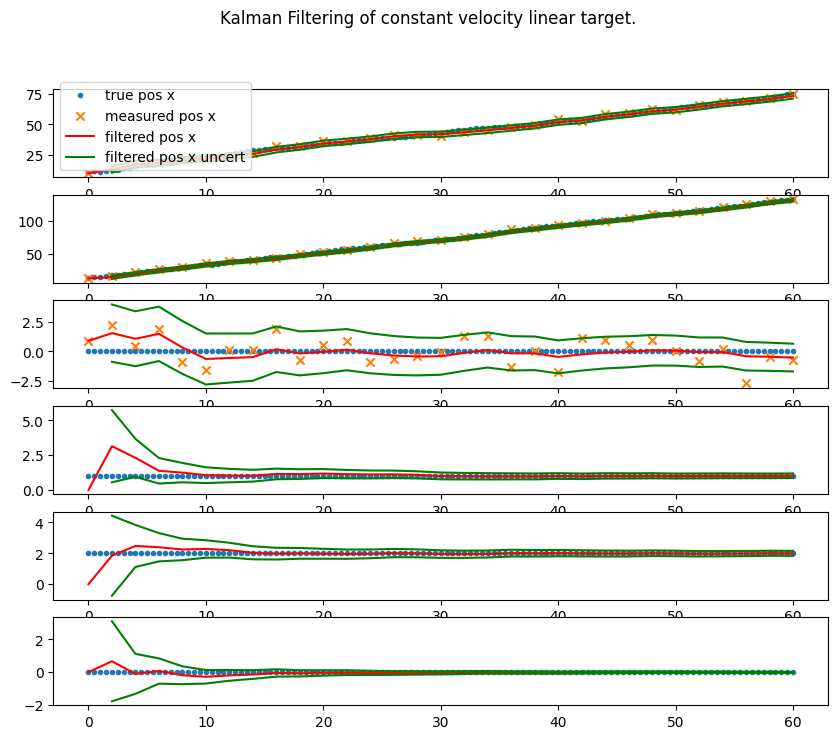

In [55]:
track = tracker.tracks[0]

fig, axs = plt.subplots(6)
fig.suptitle("Kalman Filtering of constant velocity linear target.")
fig.set_size_inches((10, 8))
axs[0].scatter([t for (t, x) in gt.history], [x[0] for (t, x) in gt.history], marker=".", label="true pos x")
axs[0].scatter(sim_records["oracle1"]["t"], sim_records["lti_object1"]["x"][0] \
               + sim_records["oracle1"]["target_x"], marker="x", label="measured pos x")

filtered_x, uncert_x, time_x = track.get_state_hist(0)

axs[0].plot(time_x, sim_records["lti_object1"]["x"][0] +filtered_x, color="red", label="filtered pos x")
axs[0].plot(time_x[1:], sim_records["lti_object1"]["x"][0] + uncert_x[1:, 0], color="green", label="filtered pos x uncert")
axs[0].plot(time_x[1:], sim_records["lti_object1"]["x"][0] + uncert_x[1:, 1], color="green")
axs[0].legend()

axs[1].scatter([t for (t, x) in gt.history], [x[1] for (t, x) in gt.history], marker=".", label="true pos x")
axs[1].scatter(sim_records["oracle1"]["t"], sim_records["lti_object1"]["y"][0] \
               + sim_records["oracle1"]["target_y"], marker="x", label="measured pos x")

filtered_y, uncert_y, time_y = track.get_state_hist(1)

axs[1].plot(time_y, sim_records["lti_object1"]["y"][0] +filtered_y, color="red", label="filtered pos y")
axs[1].plot(time_y[1:], sim_records["lti_object1"]["y"][0] + uncert_y[1:, 0], color="green", label="filtered pos y uncert")
axs[1].plot(time_y[1:], sim_records["lti_object1"]["y"][0] + uncert_y[1:, 1], color="green")

axs[2].scatter([t for (t, x) in gt.history], [x[2] for (t, x) in gt.history], marker=".", label="true pos z")
axs[2].scatter(sim_records["oracle1"]["t"], sim_records["lti_object1"]["z"][0] \
               + sim_records["oracle1"]["target_z"], marker="x", label="measured pos z")

filtered_z, uncert_z, time_z = track.get_state_hist(2)

axs[2].plot(time_z, sim_records["lti_object1"]["z"][0] +filtered_z, color="red", label="filtered pos z")
axs[2].plot(time_z[1:], sim_records["lti_object1"]["z"][0] + uncert_z[1:, 0], color="green", label="filtered pos z uncert")
axs[2].plot(time_z[1:], sim_records["lti_object1"]["z"][0] + uncert_z[1:, 1], color="green")

axs[3].scatter([t for (t, x) in gt.history], [x[3] for (t, x) in gt.history], marker=".", label="true xdot")

filtered_xdot, uncert_xdot, time_xdot = track.get_state_hist(3)

axs[3].plot(time_xdot, filtered_xdot, color="red", label="filtered xdot")
axs[3].plot(time_xdot[1:], uncert_xdot[1:, 0], color="green", label="filtered xdot uncert")
axs[3].plot(time_xdot[1:], uncert_xdot[1:, 1], color="green")

axs[4].scatter([t for (t, x) in gt.history], [x[4] for (t, x) in gt.history], marker=".", label="true ydot")

filtered_ydot, uncert_ydot, time_ydot = track.get_state_hist(4)

axs[4].plot(time_ydot, filtered_ydot, color="red", label="filtered ydot")
axs[4].plot(time_ydot[1:], uncert_ydot[1:, 0], color="green", label="filtered ydot uncert")
axs[4].plot(time_ydot[1:], uncert_ydot[1:, 1], color="green")

axs[5].scatter([t for (t, x) in gt.history], [x[5] for (t, x) in gt.history], marker=".", label="true zdot")

filtered_zdot, uncert_zdot, time_zdot = track.get_state_hist(5)

axs[5].plot(time_zdot, filtered_zdot, color="red", label="filtered zdot")
axs[5].plot(time_zdot[1:], uncert_zdot[1:, 0], color="green", label="filtered zdot uncert")
axs[5].plot(time_zdot[1:], uncert_zdot[1:, 1], color="green")

In [56]:
gt = sim._sim_objects[-1].ground_truth
track = tracker.tracks[0]

err, uncert, t = compute_error(gt, track)

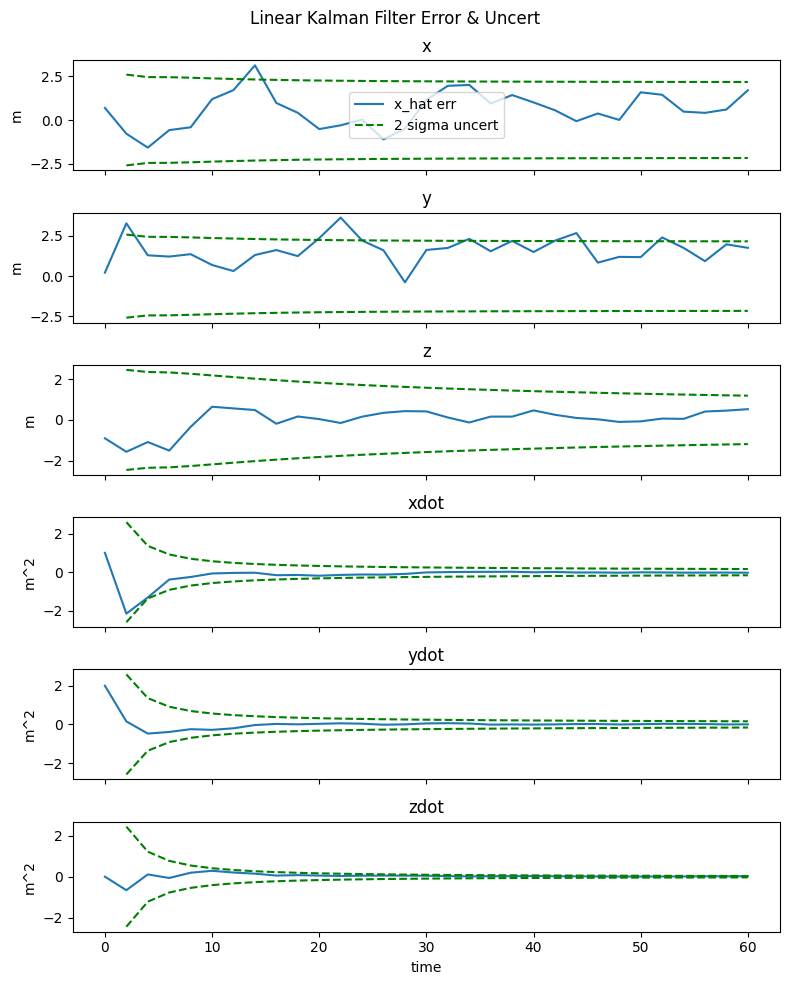

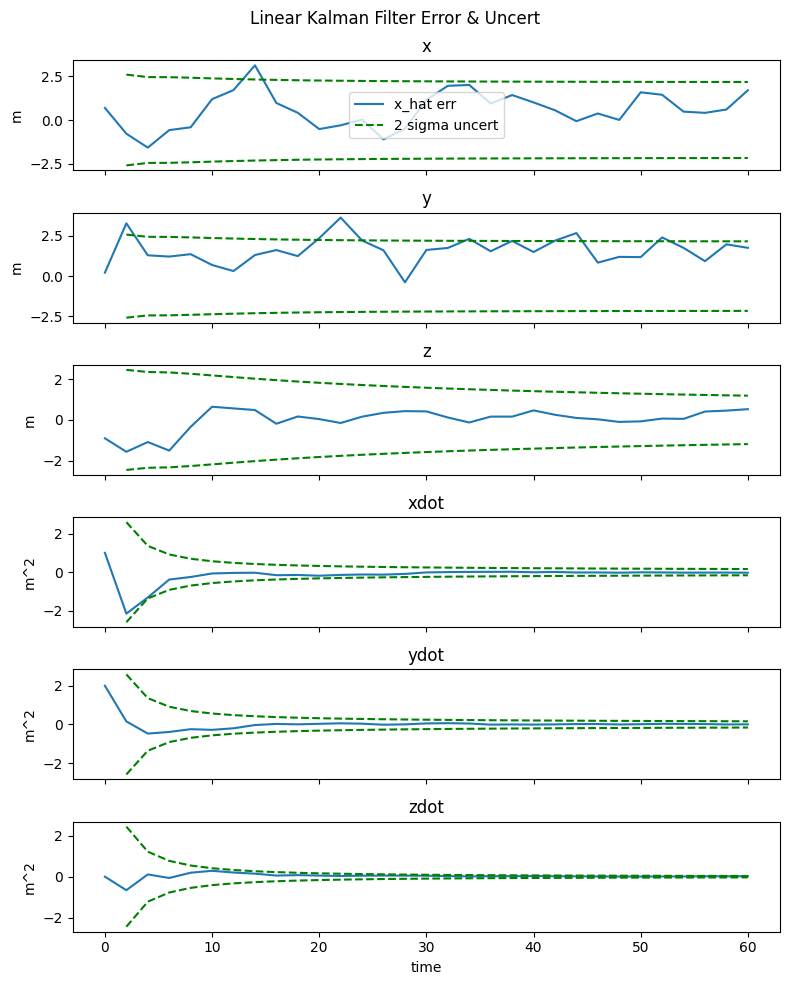

In [60]:
plot_errors(err, uncert, t, title="Linear Kalman Filter Error & Uncert")

In [15]:
tracker_params = TrackerParam(associator_type="pda",
                              initeator_type="pda",
                              deletor_type="truth",
                              pda_cr=0,
                              filter_factory=lkf_factory)

tracker = Tracker(tracker_params)

for frame in sim.meas_queue:
    tracker.process_frame(frame)

kf_record = tracker.tracks[0].filter.record()

total gated: 1


ValueError: array must not contain infs or NaNs

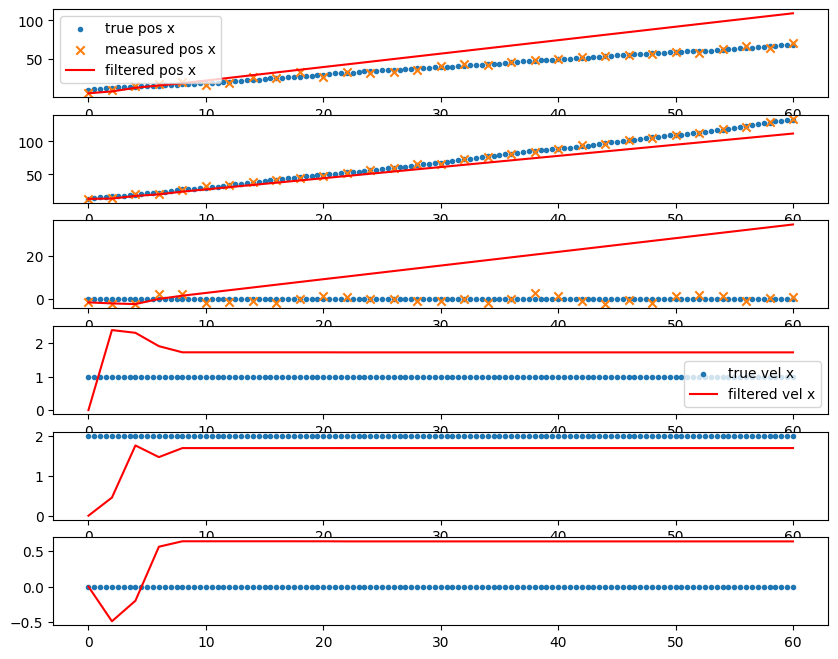

In [8]:
fig, axs = plt.subplots(6)
fig.set_size_inches((10, 8))
axs[0].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["x"], marker=".", label="true pos x")
axs[0].scatter(sim_records["oracle1"]["t"], sim_records["lti_object1"]["x"][0] \
               + sim_records["oracle1"]["target_x"], marker="x", label="measured pos x")
axs[0].plot(kf_record["t"], sim_records["lti_object1"]["x"][0] \
            + kf_record["x_hat"][:, 0], color="red", label="filtered pos x")
axs[0].legend()

axs[1].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["y"], marker=".", label="true pos y")
axs[1].scatter(sim_records["oracle1"]["t"], sim_records["lti_object1"]["y"][0] \
               + sim_records["oracle1"]["target_y"], marker="x", label="measured pos y")
axs[1].plot(kf_record["t"], sim_records["lti_object1"]["y"][0] \
            + kf_record["x_hat"][:, 1], color="red", label="filtered pos y")

axs[2].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["z"], marker=".", label="true pos z")
axs[2].scatter(sim_records["oracle1"]["t"], sim_records["oracle1"]["target_z"], marker="x", label="measured pos z")
axs[2].plot(kf_record["t"], kf_record["x_hat"][:, 2], color="red", label="filtered pos z")

axs[3].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["xdot"], marker=".", label="true vel x")
axs[3].plot(kf_record["t"], kf_record["x_hat"][:, 3], color="red", label="filtered vel x")
axs[3].legend()

axs[4].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["ydot"], marker=".", label="true vel y")
axs[4].plot(kf_record["t"], kf_record["x_hat"][:, 4], color="red", label="filtered pos y")

axs[5].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["zdot"], marker=".", label="true vel z")
axs[5].plot(kf_record["t"], kf_record["x_hat"][:, 5], color="red", label="filtered pos z")